In [1]:
#Imports
import csv
import cv2
import numpy as np
from sklearn.cross_validation import train_test_split
import sklearn
import random
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda,Cropping2D,Dropout,Activation
from keras.layers.convolutional import Convolution2D 
from keras.layers.pooling import MaxPooling2D
from keras.initializations import glorot_normal
import matplotlib.pyplot as plt
from keras.utils.visualize_util import plot
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Center0,Left1,Right2,Angle3,Throttle4,Break5,Speed6 (Access from 0-6)
lines=[]
with open("../Data/driving_log.csv") as csvfile:
    reader=csv.reader(csvfile)
    for line in reader:
        lines.append(line)
#Split into sets
TrainSamples, ValidationSamples=train_test_split(lines,test_size=0.2)
print("DataSet Ready")

DataSet Ready


In [3]:
print(len(TrainSamples))
print(len(ValidationSamples))

4426
1107


(160, 320, 3)


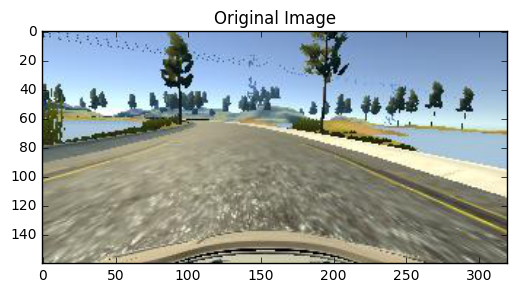

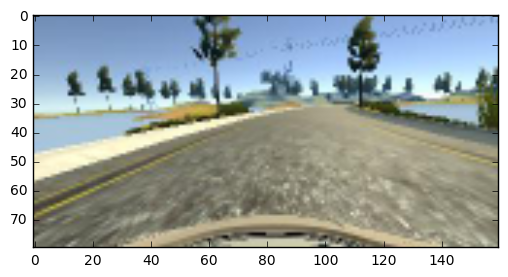

In [4]:
#Sample PreProcessing
SamImage=cv2.imread(TrainSamples[0][0])
SamImage=cv2.cvtColor(SamImage,cv2.COLOR_BGR2RGB)
plt.figure(1)
plt.title("Original Image")
plt.imshow(SamImage)
print(SamImage.shape)
SamImage=cv2.resize(SamImage,(160,80),cv2.INTER_CUBIC)
SamImage=cv2.flip(SamImage,1)
plt.figure(2)
plt.axes().set_aspect('equal')
plt.imshow(SamImage)

In [5]:
NewShape=[80,160]   #Shape of resized image. Half of dimensions
def PreProcess(Img):
    Image=Img
    Image=cv2.resize(Image,(NewShape[1],NewShape[0]),cv2.INTER_CUBIC)
    FlipImage=cv2.flip(Image,1)
    return Image,FlipImage  #Returns Resized image and flipped image

In [6]:
#Collect data from files
SteerCorrection=0.25   #Correction for steering from center camera 
Multiplier=6           #Number of images generated per sample
#Generators
def BatchGenerator(Data,BatchSize=1):
    NumSamples=len(Data)
    while 1:
        random.shuffle(Data)                             #Shuffle Data so images come in random order
        for offset in range(0,NumSamples,BatchSize):     #Increment offset by BatchSize
            BatchSample=Data[offset:offset+BatchSize]    #Select batch size number of Data samples
        #Create an empty numpy array for holding flipped and original images
        TrainFeatures=np.zeros((len(BatchSample)*Multiplier,NewShape[0],NewShape[1],3))
        #Numpy array to hold corresponding labels
        TrainLabels=np.zeros(len(BatchSample)*Multiplier)
        i=0
        for Sample in BatchSample:
            #Images
            CenterImg=np.asarray(cv2.imread(Sample[0]))
            LeftImg=np.asarray(cv2.imread(Sample[1].strip()))  
            RightImg=np.asarray(cv2.imread(Sample[2].strip()))
            #PreProcess Images
            CenterImg,CenterFlipImg=PreProcess(CenterImg)
            LeftImg,LeftFlipImg=PreProcess(LeftImg)
            RightImg,RightFlipImg=PreProcess(RightImg)
            #Steering Angles
            CenterAngle=float(Sample[3])
            LeftAngle=(CenterAngle+SteerCorrection)
            RightAngle=(CenterAngle-SteerCorrection)
            #Image and Angle Accumulation
            TrainFeatures[i]=CenterImg
            TrainLabels[i]=CenterAngle
            i=i+1
            TrainFeatures[i]=LeftImg
            TrainLabels[i]=LeftAngle
            i=i+1
            TrainFeatures[i]=RightImg
            TrainLabels[i]=RightAngle
            i=i+1
            TrainFeatures[i]=CenterFlipImg
            TrainLabels[i]=(-1*CenterAngle)
            i=i+1
            TrainFeatures[i]=LeftFlipImg
            TrainLabels[i]=(-1*LeftAngle)
            i=i+1
            TrainFeatures[i]=RightFlipImg
            TrainLabels[i]=(-1*RightAngle)
            yield sklearn.utils.shuffle(TrainFeatures,TrainLabels)

In [7]:
#Training and Validation Data
GeneratedTrain=BatchGenerator(TrainSamples,50)
GeneratedVal=BatchGenerator(ValidationSamples,50)


In [8]:
#Network to drive the car
FilShape=[5,5,5,3,3]        #Convolutional Filter Shape
NumFils=[24,36,48,64,64]    #Number of Filters
FCSize=[600,100,50,10]      #Fully Connection layers outputs

#Model
model=Sequential()
#PreProcessing
model.add(Lambda(lambda x:x/255.0-0.5,input_shape=(NewShape[0],NewShape[1],3)))
model.add(Cropping2D(cropping=((30,12),(0,0)))) #Crop 70 pixels on top and 25 pixels on bottom
#Conv Layer 1- Initialized with Xavier weight initialization
model.add(Convolution2D(NumFils[0],FilShape[0],FilShape[0],activation='relu'
                        ,init='glorot_normal'))
#CL2
model.add(Convolution2D(NumFils[1],FilShape[1],FilShape[1],activation='relu'
                        ,init='glorot_normal'))
#CL3
model.add(Convolution2D(NumFils[2],FilShape[2],FilShape[2],activation='relu'
                        ,init='glorot_normal'))
#CL4
model.add(Convolution2D(NumFils[3],FilShape[3],FilShape[3],activation='relu'
                        ,init='glorot_normal'))
#CL5
model.add(Convolution2D(NumFils[4],FilShape[4],FilShape[4],activation='relu'
                        ,init='glorot_normal'))
#Flatten
model.add(Flatten())
#All layers have a dropout of 0.15
#FC1
model.add(Dense(FCSize[0],activation='relu',init='glorot_normal'))
model.add(Dropout(0.15))
#FC2
model.add(Dense(FCSize[1],activation='relu',init='glorot_normal'))
model.add(Dropout(0.15))
#FC3
model.add(Dense(FCSize[2],activation='relu',init='glorot_normal'))
model.add(Dropout(0.15))
#FC4
model.add(Dense(FCSize[3],activation='relu',init='glorot_normal'))
model.add(Dense(1))


In [9]:
#Model
model.compile(loss='mse',optimizer='adam')
BestVal=20000 #Big value so that best value gets stored
#Run 10 runs and store model whenever its validation loss is less
for i in range(0,10):
    FitData=model.fit_generator(GeneratedTrain,samples_per_epoch=len(TrainSamples),validation_data=GeneratedVal,
                    nb_val_samples=len(ValidationSamples),nb_epoch=1)
    if((FitData.history['val_loss'][0])<BestVal):
        BestVal=FitData.history['val_loss'][0]
        print("Saving Model  "+str(i))
        model.save("Model"+str(i)+".h5")
print("Done...")

Epoch 1/1
4368/4426 [============================>.] - ETA: 0s - loss: 0.0299

/home/krishna/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


4524/4426 [==============================] - 11s - loss: 0.0291 - val_loss: 0.0408
Saving Model  0
Epoch 1/1
4524/4426 [==============================] - 14s - loss: 0.0233 - val_loss: 0.0219
Saving Model  1
Epoch 1/1
4524/4426 [==============================] - 13s - loss: 0.0127 - val_loss: 0.0176
Saving Model  2
Epoch 1/1
4524/4426 [==============================] - 15s - loss: 0.0190 - val_loss: 0.0394
Epoch 1/1
4524/4426 [==============================] - 7s - loss: 0.0106 - val_loss: 0.0184
Epoch 1/1
4524/4426 [==============================] - 7s - loss: 0.0208 - val_loss: 0.0346
Epoch 1/1
4524/4426 [==============================] - 7s - loss: 0.0086 - val_loss: 0.0363
Epoch 1/1
4524/4426 [==============================] - 7s - loss: 0.0156 - val_loss: 0.0300
Epoch 1/1
4524/4426 [==============================] - 7s - loss: 0.0125 - val_loss: 0.0348
Epoch 1/1
4524/4426 [==============================] - 7s - loss: 0.0146 - val_loss: 0.0304
Done...
